Natural Frequencies (Hz): [ 4.92713841 25.18553158]
Mode Shapes (each column corresponds to a mode):
[[-0.67710949 -0.73588229]
 [-0.73588229  0.67710949]]


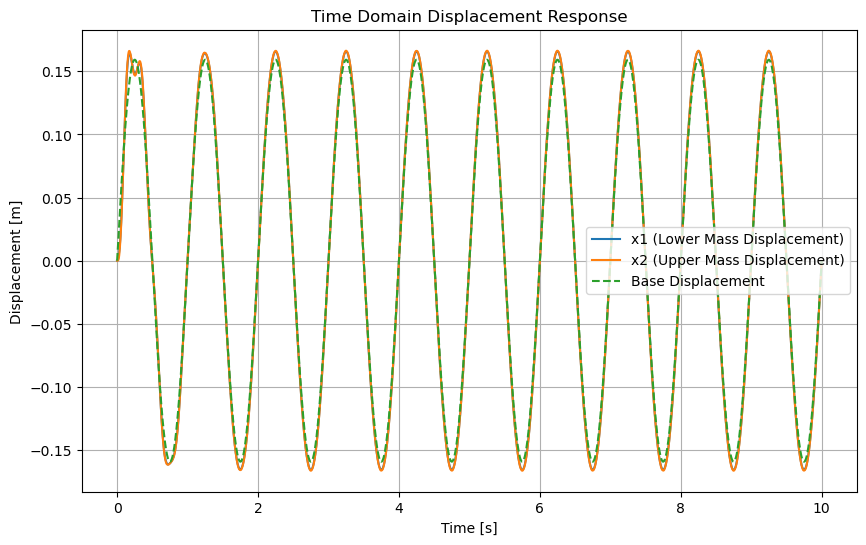

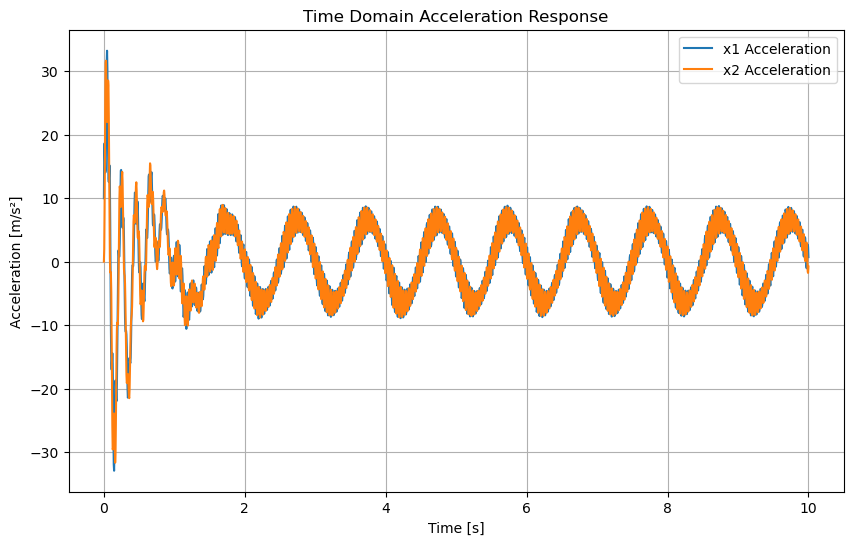

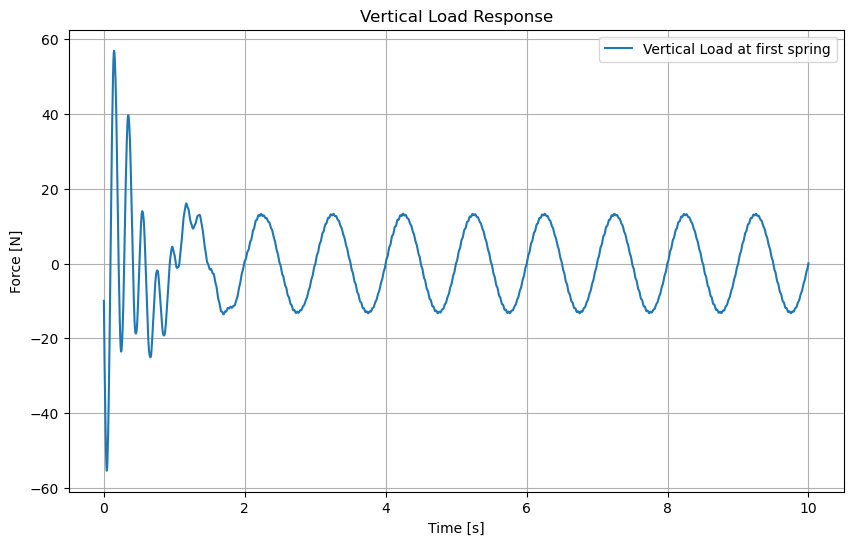

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import eigh

# System Parameters
m1 = 1.0       # Lower mass [kg]
c1 = 10.0      # Lower damping [Ns/m]
k1 = 2000.0    # Lower stiffness [N/m]

m2 = 1.0       # Upper mass [kg]
c2 = 2.0       # Upper damping [Ns/m]
k2 = 12000.0   # Upper stiffness [N/m]

# Base excitation: harmonic excitation with unit velocity at t=0
f_exc = 1.0  # excitation frequency in Hz
omega_exc = 2 * np.pi * f_exc

def base_excitation(t):
    """
    Returns the base displacement and velocity for a harmonic base excitation.
    x0(t) = sin(omega_exc*t)/omega_exc   and   x0_dot(t) = cos(omega_exc*t)
    """
    x0 = np.sin(omega_exc * t) / omega_exc
    x0_dot = np.cos(omega_exc * t)
    return x0, x0_dot

def odes(t, y):
    """
    Defines the state-space ODEs for the 2-DOF system.
    State vector: y = [x1, x1_dot, x2, x2_dot]
    """
    x1, x1_dot, x2, x2_dot = y
    x0, x0_dot = base_excitation(t)
    
    # Equation of motion for mass 1:
    # m1*x1'' = - c1*(x1_dot - x0_dot) - k1*(x1 - x0) - c2*(x1_dot - x2_dot) - k2*(x1 - x2)
    x1_ddot = (-c1*(x1_dot - x0_dot) - k1*(x1 - x0) - c2*(x1_dot - x2_dot) - k2*(x1 - x2)) / m1
    
    # Equation of motion for mass 2:
    # m2*x2'' = - c2*(x2_dot - x1_dot) - k2*(x2 - x1)
    x2_ddot = (-c2*(x2_dot - x1_dot) - k2*(x2 - x1)) / m2
    
    return [x1_dot, x1_ddot, x2_dot, x2_ddot]

# Time span for simulation
t_start = 0.0
t_end = 10.0
num_points = 2000
t_eval = np.linspace(t_start, t_end, num_points)

# Initial conditions: system initially at rest (all displacements and velocities are zero)
y0 = [0.0, 0.0, 0.0, 0.0]

# Solve the ODE system
sol = solve_ivp(odes, (t_start, t_end), y0, t_eval=t_eval)

# Compute accelerations by re-evaluating the ODE function
x1_ddot = np.zeros_like(sol.t)
x2_ddot = np.zeros_like(sol.t)
for i, t in enumerate(sol.t):
    derivs = odes(t, sol.y[:, i])
    x1_ddot[i] = derivs[1]
    x2_ddot[i] = derivs[3]

# Compute vertical load in the lower suspension:
# F_lower(t) = k1*(x1 - x0) + c1*(x1_dot - x0_dot)
base_disp = np.array([base_excitation(t)[0] for t in sol.t])
base_vel = np.array([base_excitation(t)[1] for t in sol.t])
F_lower = k1*(sol.y[0, :] - base_disp) + c1*(sol.y[1, :] - base_vel)

# ------------------------------
# Eigenvalue Analysis: Natural Frequencies and Mode Shapes
# ------------------------------
# For the free-vibration (undamped) system (assuming base displacement is zero)
M_mat = np.array([[m1, 0],
                  [0, m2]])
K_mat = np.array([[k1 + k2, -k2],
                  [-k2,     k2]])

# Solve the generalized eigenvalue problem: K * phi = omega^2 * M * phi
eigvals, eigvecs = eigh(K_mat, M_mat)
omega_n = np.sqrt(eigvals)        # Natural frequencies in rad/s
f_n = omega_n / (2 * np.pi)         # Convert rad/s to Hz

print("Natural Frequencies (Hz):", f_n)
print("Mode Shapes (each column corresponds to a mode):")
print(eigvecs)

# ------------------------------
# Plotting the time-domain responses
# ------------------------------
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0, :], label='x1 (Lower Mass Displacement)')
plt.plot(sol.t, sol.y[2, :], label='x2 (Upper Mass Displacement)')
plt.plot(sol.t, base_disp, '--', label='Base Displacement')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Time Domain Displacement Response')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(sol.t, x1_ddot, label='x1 Acceleration')
plt.plot(sol.t, x2_ddot, label='x2 Acceleration')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.title('Time Domain Acceleration Response')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(sol.t, F_lower, label='Vertical Load at first spring')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Vertical Load Response')
plt.legend()
plt.grid(True)

plt.show()


# Frequency Domain

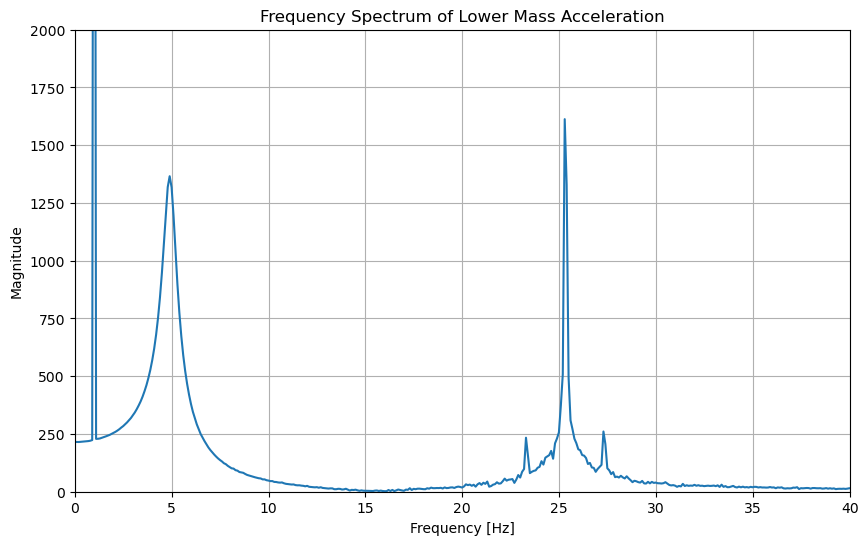

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assume sol.t is your time array and x1_ddot is your computed acceleration
# Compute FFT
N = len(sol.t)
dt = sol.t[1] - sol.t[0]
freqs = np.fft.fftfreq(N, d=dt)
X1_fft = np.fft.fft(x1_ddot)

# Only take the positive frequencies for analysis
idx = np.where(freqs >= 0)
freqs_positive = freqs[idx]
X1_fft_positive = X1_fft[idx]

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(freqs_positive, np.abs(X1_fft_positive))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0,40)
plt.ylim(0,2000)
plt.title('Frequency Spectrum of Lower Mass Acceleration')
plt.grid(True)
plt.show()
